# Spatial Stochastic Simulation with SpatialPy

## Definition of the model

Here we illustrate how to implement the model describet in [Sturrock M, Hellander A, Matzavinos A, Chaplain MAJ. 2013 Spatial stochastic modelling of the Hes1 gene regulatory network: intrinsic noise can explain heterogeneity in embryonic stem cell differentiation. J R Soc Interface 10:20120988]

You may need to install specific version to get this notebook to work:

python3 -m pip install meshio==2.3.10

python3 -m pip install pygmsh==5.0.2

### Imports and definitions

In [1]:
%matplotlib inline

import os
import sys
sys.path.insert(1, "../..")
import numpy as np
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class Nucleus(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 <= 3**2

In [3]:
class Cytoplasm(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 > 3**2

### Model

In [4]:
class hes1(spatialpy.Model):
    def __init__(self, model_name="hes1"):
        spatialpy.Model.__init__(self, model_name)

        #Species
        Pf = spatialpy.Species(name="Pf", diffusion_constant=0)
        Po = spatialpy.Species(name="Po", diffusion_constant=0)
        mRNA = spatialpy.Species(name="mRNA", diffusion_constant=6e-1)
        protein = spatialpy.Species(name="protein", diffusion_constant=6e-1)
        self.add_species([Pf, Po, mRNA, protein])
        
        #Restrict to promoter_site
        self.restrict(Pf, 3)
        self.restrict(Po, 3)
        
        #Domain
        self.domain = spatialpy.Domain.read_msh_file("mesh/cell.msh")
        
        #Types
        self.set_type(Cytoplasm(), 1)
        self.set_type(Nucleus(), 2)
        # promoter site
        self.domain.type[self.domain.closest_vertex([0]*3)] = 3

        #Parameters
        k1 = spatialpy.Parameter(name="k1", expression=1e9)
        k2 = spatialpy.Parameter(name="k2", expression=0.1)
        alpha_m = spatialpy.Parameter(name="alpha_m", expression=3)
        alpha_m_gamma = spatialpy.Parameter(name="alpha_m_gamma", expression=0.1)
        alpha_p = spatialpy.Parameter(name="alpha_p", expression=1)
        mu_m = spatialpy.Parameter(name="mu_m", expression=0.015)
        mu_p = spatialpy.Parameter(name="mu_p", expression=0.043)
        self.add_parameter([k1, k2, alpha_m, alpha_m_gamma, alpha_p, mu_m, mu_p])


        #Reactions
        R1 = spatialpy.Reaction(name="R1", rate=k1, restrict_to=3,
                                reactants={Pf:1,protein:1}, products={Po:1})
        R2 = spatialpy.Reaction(name="R2", rate=k2, restrict_to=3,
                                reactants={Po:1}, products={Pf:1,protein:1})
        R3 = spatialpy.Reaction(name="R3", rate=alpha_m, restrict_to=3,
                                reactants={Pf:1}, products={Pf:1,mRNA:1})
        R4 = spatialpy.Reaction(name="R4", rate=alpha_m_gamma, restrict_to=3,
                                reactants={Po:1}, products={Po:1,mRNA:1})
        R5 = spatialpy.Reaction(name="R5", rate=alpha_p, restrict_to=1,
                                reactants={mRNA:1}, products={mRNA:1,protein:1})
        R6 = spatialpy.Reaction(name="R6", rate=mu_m, reactants={mRNA:1})
        R7 = spatialpy.Reaction(name="R7", rate=mu_p, reactants={protein:1})
        self.add_reaction([R1, R2, R3, R4, R5, R6, R7])

        #Initail Conditions
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Pf, 1, types=[3]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(protein, 60, types=[1]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(mRNA, 10, types=[2]))
        
        self.timespan(range(1200), timestep_size=1)
        #self.timespan(range(200), timestep_size=1)

In [5]:
model = hes1()

## Running the model and processing the results

In [6]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 2.61 s, sys: 7.8 ms, total: 2.61 s
Wall time: 9.8 s
/tmp/spatialpy_build_i4ralef_


In [7]:
#%time result = model.run(debug_level=0)
%time result = sol.run()

CPU times: user 7.12 ms, sys: 91 µs, total: 7.21 ms
Wall time: 51.8 s


### Plot the evolution of the copy number of a given species

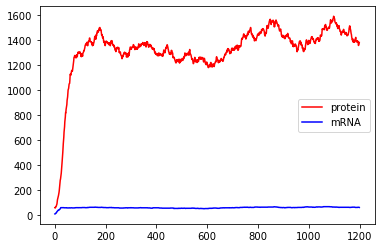

In [8]:
protein = result.get_species("protein")
proteinsum = np.sum(protein,axis=1)
plt.plot(model.tspan,proteinsum,'r', label='protein')
mRNA = result.get_species("mRNA")
mRNAsum=np.sum(mRNA[:],axis=1)
plt.plot(model.tspan,mRNAsum,'b', label='mRNA')
plt.legend(loc='best')

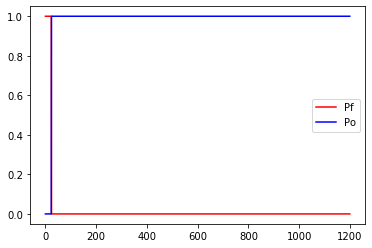

In [9]:
pf = np.sum(result.get_species("Pf"),axis=1)
po = np.sum(result.get_species("Po"),axis=1)
plt.plot(model.tspan,pf,'r',label="Pf")
plt.plot(model.tspan,po,'b',label="Po")
plt.legend(loc="best")